# Persistence homology example for molecules

This is a notebook that will show you how chemical structures are turned into persistence diagrams using benzene as an example. 

Figure below demonstrates how the betti numbers change with radius and points (simplex-0) become connected via lines (simplex-1), triangles (simplex-2) or tetrahedra (simplex-3). 

For figure below:

a. small radius, there are 12 points, 

b. radius is equal to half a $r_{CH}$ bond, the connected regions merge creating 6 clusters, 

c. radius is equal to half the H-H distance in a H-C-H angle ($\theta_{HCH}$), the clusters merge to create a single torus (flat donut-like object)

d. radius is equal to half the C-C distance, topologically speaking the system is still a torus, although the aperture is now smaller

e. radius is large enough to merge and close the aperture, and now benzene is topologically a cluster again. 

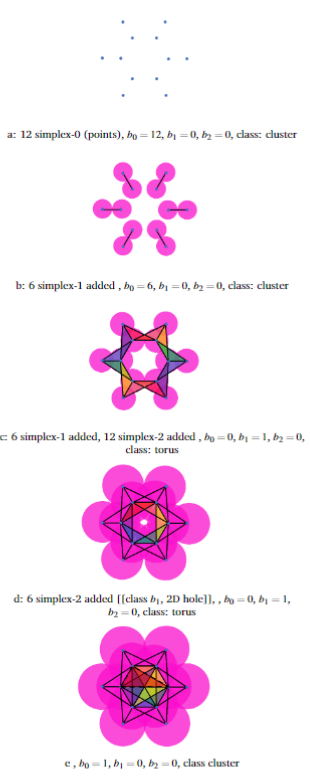

In [ ]:
# lets load our libraries
#!conda install -y -c conda-forge numpy=1.19.5
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
import tensorflow as tf
import os
import sys
import rdkit
import h5py

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri 
import rdkit.Chem
import rdkit.Chem.AllChem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import mpl_toolkits.mplot3d
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from collections import Counter

print("TensorFlow version: " + tf.__version__)

# topology stuff 
from gtda.mapper import plot_interactive_mapper_graph
from gtda.plotting import plot_point_cloud, plot_betti_curves
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import NumberOfPoints
from gtda.diagrams import Amplitude
from sklearn.pipeline import make_union, Pipeline

sys.path.append(os.path.join(os.getcwd(), r"graphs_and_topology_for_chemistry"))

                
results_dir = os.path.join(os.getcwd(), r"results")
try:
  os.mkdir(results_dir)                
except FileExistsError:     
  pass  
from molecule import Molecule
from pdbmolecule import PDBMolecule
from mol2molecule import Mol2Molecule

import helper_functions as h
#from projection.face import Face

## Functions

In [ ]:
def generate_structure_from_smiles(smiles):

    # Generate a 3D structure from smiles

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    status = AllChem.EmbedMolecule(mol)
    status = AllChem.UFFOptimizeMolecule(mol)

    conformer = mol.GetConformer()
    coordinates = conformer.GetPositions()
    coordinates = np.array(coordinates)

    #atoms = get_atoms(mol)

    return coordinates 

def smiles_to_persistence_diagrams(smiles):
    coords=generate_structure_from_smiles(smiles)
    # makes a point cloud version of the structure
    # there are no atom types

    # Track connected components, loops, and voids
    homology_dimensions = [0, 1, 2]

    # Collapse edges to speed up H2 persistence calculation!
    persistence = VietorisRipsPersistence(
        metric="euclidean",
        homology_dimensions=homology_dimensions,
        n_jobs=6,
        collapse_edges=True,
    )
    reshaped_coords=coords[None, :, :]
    diagrams_basic = persistence.fit_transform(reshaped_coords)
    return coords, diagrams_basic

def generate_structure_from_pdb(data_dir,
                               filename):

    # Generate a 3D structure from smiles

    mol = rdkit.Chem.rdmolfiles.MolFromPDBFile(
        os.path.join(data_dir, filename))
    mol = Chem.AddHs(mol)

    status = AllChem.EmbedMolecule(mol)
    status = AllChem.UFFOptimizeMolecule(mol)

    conformer = mol.GetConformer()
    coordinates = conformer.GetPositions()
    coordinates = np.array(coordinates)

    #atoms = get_atoms(mol)

    return coordinates 

def generate_structure_from_mol(data_dir,
                               filename):

    # Generate a 3D structure from smiles

    mol = rdkit.Chem.rdmolfiles.MolFromMolFile(
        os.path.join(data_dir, filename))
    mol = Chem.AddHs(mol)

    status = AllChem.EmbedMolecule(mol)
    status = AllChem.UFFOptimizeMolecule(mol)

    conformer = mol.GetConformer()
    coordinates = conformer.GetPositions()
    coordinates = np.array(coordinates)

    #atoms = get_atoms(mol)

    return coordinates

def coords_to_persistence_diagrams(coords):
    # makes a point cloud version of the structure
    # there are no atom types

    # Track connected components, loops, and voids
    homology_dimensions = [0, 1, 2]

    # Collapse edges to speed up H2 persistence calculation!
    persistence = VietorisRipsPersistence(
        metric="euclidean",
        homology_dimensions=homology_dimensions,
        n_jobs=6,
        collapse_edges=True,
    )
    reshaped_coords=coords[None, :, :]
    diagrams_basic = persistence.fit_transform(reshaped_coords)
    return coords, diagrams_basic

## Testing out some simple compounds

Here we use benzene as an example

In [ ]:
# the SMILES string
benzene_smiles = "c1ccccc1"
# this makes a molecule object using rdkit
benzene = rdkit.Chem.MolFromSmiles(benzene_smiles)


In [ ]:
benzene

 This code creates the persistence diagram and plots the coordinates. To save the images click on the camera icon.

In [ ]:
# creates the coordinates of the point cloud and the persistence diagram
coords, diagrams_basic = smiles_to_persistence_diagrams(benzene_smiles)
# plots the point cloud
plot_point_cloud(coords)

This is the persistence diagram for benzene. Right click to save the diagram.

In [ ]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

This is interesting, there are 6 CH bonds at about 1.09A, and we have 6 features dying at 1.08, these are the C-H bonds (fig 1b). Then we have connection between the C-H clusters dying at at 1.39 (fig 1.c), the torus is born at this radius. The torus dies at 2.4 and then I think the entire thing collapes into a point at 2.8.

`diagrams_basic` is the list of points plotted in the diagram, you'll see that the red points on the figure above contain multiple overlapping points due to the symmetry of benzene.

In [ ]:
diagrams_basic

The code below makes a simple barcode plot. The red lines are the clusters, which merge to a torus (blue) and finally collapse.

In [ ]:
x_val_a = [x for x in diagrams_basic[0][:,0]]
x_val_b = [x for x in diagrams_basic[0][:,1]]
y_val = [-x for x in range(len(x_val_a))]
col = [int(x) for x in diagrams_basic[0][:,2]]

col=['r','r','r','r','r','r','r','r','r','r','r','b','g']

for i in range(len(x_val_a)):
    plt.plot([x_val_a[i],x_val_b[i]],[y_val[i],y_val[i]], c=col[i])
plt.xlabel('Filter / Angstroms')
plt.yticks([])

This makes a Betti curve of the same information.

In [ ]:
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance

BC = BettiCurve()

X_betti_curves = BC.fit_transform(diagrams_basic)

BC.plot(X_betti_curves)

# Now you've looked at the persistence diagrams for benzene you can try anything you can get a SMILES string for or a pdb file for (see below for a Buckyball example).

# Buckyball

Loads a pdb file

In [ ]:
# this loads a bucky ball from a pdb file
pdb_file = r"c_60.pdb"
pdb_file_location = os.path.join(os.getcwd(), pdb_file)
bb=rdkit.Chem.rdmolfiles.MolFromPDBFile(pdb_file_location)
bb

Gets coordinates of the atoms

Makes coordinates of the atoms and the persistence diagram.

In [ ]:
coords = generate_structure_from_pdb(os.getcwd(),pdb_file)
coords, diagrams_basic = coords_to_persistence_diagrams(coords)

Plots the coordinates as a pointcloud.

In [ ]:
plot_point_cloud(coords)

Finally, make the persistence diagram.

In [ ]:
# Circle shape persistence diagram
plot_diagram(diagrams_basic[0])

Now you can make some nice figures about persistent homology if you want to!